This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [10]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
import os
import seaborn as sns
import json

from src_python.mutation_filter import MutationFilter
from src_python.cell_tree import CellTree
from src_python.mutation_tree import MutationTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, create_mutation_matrix, \
    create_genotype_matrix, mut_count_distance

In [11]:
path = "../data/simulated_data"

n_cells = [50, 100, 100]
n_mut = [100, 100, 50]
n_tests = 100
clones = ["5", "10", "20", ""]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
likelihood_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}

In [18]:
n_round = 0

config = load_config_and_set_random_seed()

mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                                    genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                                    dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                                    dropout_direction_prob=config["dropout_direction"],
                                    overdispersion_h=config["overdispersion_h"])

if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")

                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)


                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(gt)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # flipped_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)
                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
                # mut_location_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_mutation_location", f"sciterna_mutation_location_{n_round}r{t}.txt"), dtype=int)
                # mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)
                # ct_sciterna.fit_llh(llh_1, llh_2)

                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.mut_loc = mut_location[selected]

                ct_sciterna.use_parent_vec(sciterna_parent_vec)
                # ct_sciterna.flipped = flipped_sciterna
                # ct_sciterna.mut_loc = mut_location_sciterna

                # n_true_clones = len(np.unique(genotype_gt, axis=0, return_counts=True)[0]) - 1
                # ct_sciterna.update_mut_loc_experimental(n_true_clones)

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                # mut_matrix = create_mutation_matrix(sciterna_parent_vec, ct_sciterna.mut_loc, ct_sciterna)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sciterna.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)
                #
                # m_dist = mut_count_distance(genotype_gt, genotype_matrix)
                # mut_count_distances.append(m_dist)

                # likelihoods.append((ct_sciterna.joint - ct_gt.joint) / (ct_sciterna.n_cells * ct_sciterna.n_mut))

                # graph_gt = ct_gt.to_graphviz()
                # graph_sciterna = ct_sciterna.to_graphviz()
                # graph_gt.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_gt_{t}.png"), format='png', cleanup=True)
                # graph_sciterna.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_sciterna_{n_round}r{t}.png"), format='png', cleanup=True)
                # sns.heatmap(genotype_gt)
                # plt.title(f"Genotype Matrix GT {t}")
                # plt.show()
                # sns.heatmap(genotype_predicted)
                # plt.title(f"Genotype Matrix Predicted {t}")
                # plt.show()
                #
                # sns.heatmap(np.abs(genotype_gt - genotype_predicted))
                # plt.title(f"Genotype Matrix Difference {t}")
                # plt.show()
                #
                # sns.heatmap(alt/(alt + ref))
                # plt.title(f"VAF Matrix {t}")
                # plt.show()

            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.047709  mean abs difference of vafs predicted
3.849632653061225  mean path length distance
13.108579591836735  mean mutation count distance
0.048263  mean abs difference of vafs predicted
3.5796979591836737  mean path length distance
11.26382857142857  mean mutation count distance
0.04835199999999999  mean abs difference of vafs predicted
3.417518367346938  mean path length distance
10.346546938775509  mean mutation count distance
0.036259  mean abs difference of vafs predicted
3.624848979591837  mean path length distance
5.0656897959183675  mean mutation count distance
0.0298285  mean abs difference of vafs predicted
5.173074747474748  mean path length distance
9.387315151515152  mean mutation count distance
0.0328655  mean abs difference of vafs predicted
4.9057959595959595  mean path length distance
8.367096969696968  mean mutation count distance
0.030238  mean abs difference of vafs predicted
4.6117353535353525  mean path length distance
6.940092929292929  mean mutation count dis

In [13]:
genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
likelihood_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                vaf_pred_path = os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                vaf_pred = np.loadtxt(vaf_pred_path, dtype=float)

                if vaf_pred.shape != (n_c, n_m):
                    print("Variants were filtered out, skipping this test")
                    continue
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                genotype_predicted = np.round(vaf_pred * 2) / 2
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sclineager = CellTree(n_c)
                # ct_sclineager.fit_llh(llh_1, llh_2)
                #
                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()
                #
                ct_sclineager.use_parent_vec(sclineager_parent_vec)
                # ct_sclineager.update_all()
                #
                # mut_matrix = create_mutation_matrix(sclineager_parent_vec, ct_sclineager.mut_loc, ct_sclineager)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sclineager.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix))
                # differences.append(np.mean(np.abs(genotype_matrix - genotype_gt)))

                # likelihoods.append((ct_sclineager.joint - ct_gt.joint) / (ct_sclineager.n_cells * ct_sclineager.n_mut))

            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SClineager"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.079424  mean abs difference of vafs predicted
3.5451918367346944  mean path length distance
nan  mean likelihood difference
13.045028571428574  mean mutation count distance


C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.087604  mean abs difference of vafs predicted
3.5834857142857146  mean path length distance
nan  mean likelihood difference
10.190269387755102  mean mutation count distance
0.08817200000000001  mean abs difference of vafs predicted
3.5959265306122448  mean path length distance
nan  mean likelihood difference
8.631542857142858  mean mutation count distance
Variants were filtered out, skipping this test
0.07562121212121212  mean abs difference of vafs predicted
3.6671614100185526  mean path length distance
nan  mean likelihood difference
8.49118944547516  mean mutation count distance
0.066049  mean abs difference of vafs predicted
4.164391919191919  mean path length distance
nan  mean likelihood difference
12.981226262626262  mean mutation count distance
0.0798805  mean abs difference of vafs predicted
4.1072848484848485  mean path length distance
nan  mean likelihood difference
12.390274747474745  mean mutation count distance
0.0666995  mean abs difference of vafs predicted
4.05540606

In [14]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
likelihood_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue

                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)
        
                gt = np.loadtxt(genotype_path, dtype=str).T
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")
                
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_dendro = CellTree(n_c)
                # ct_dendro.fit_llh(llh_1, llh_2)

                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()

                ct_dendro.use_parent_vec(dendro_parent_vec)
                # ct_dendro.update_all()

                # mut_matrix = create_mutation_matrix(dendro_parent_vec, ct_dendro.mut_loc, ct_dendro)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_dendro.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix.T))
                # differences.append(np.mean(np.abs(genotype_matrix.T - genotype_gt)))
                # likelihoods.append((ct_dendro.joint - ct_gt.joint) / (ct_dendro.n_cells * ct_dendro.n_mut))

                    
            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.09094100000000001  mean abs difference of vafs predicted
3.5144571428571423  mean path length distance
6.067468686868688  mean mutation count distance
0.112867  mean abs difference of vafs predicted
3.5457551020408165  mean path length distance
6.576989898989899  mean mutation count distance
0.109229  mean abs difference of vafs predicted
3.517085714285715  mean path length distance
5.961739393939394  mean mutation count distance
0.069421  mean abs difference of vafs predicted
3.538073469387756  mean path length distance
4.737743434343434  mean mutation count distance
0.052876000000000006  mean abs difference of vafs predicted
4.097846464646465  mean path length distance
7.712444444444444  mean mutation count distance
0.08790949999999999  mean abs difference of vafs predicted
4.076515151515152  mean path length distance
11.70283434343434  mean mutation count distance
0.08951100000000001  mean abs difference of vafs predicted
4.001769696969697  mean path length distance
10.54822828282

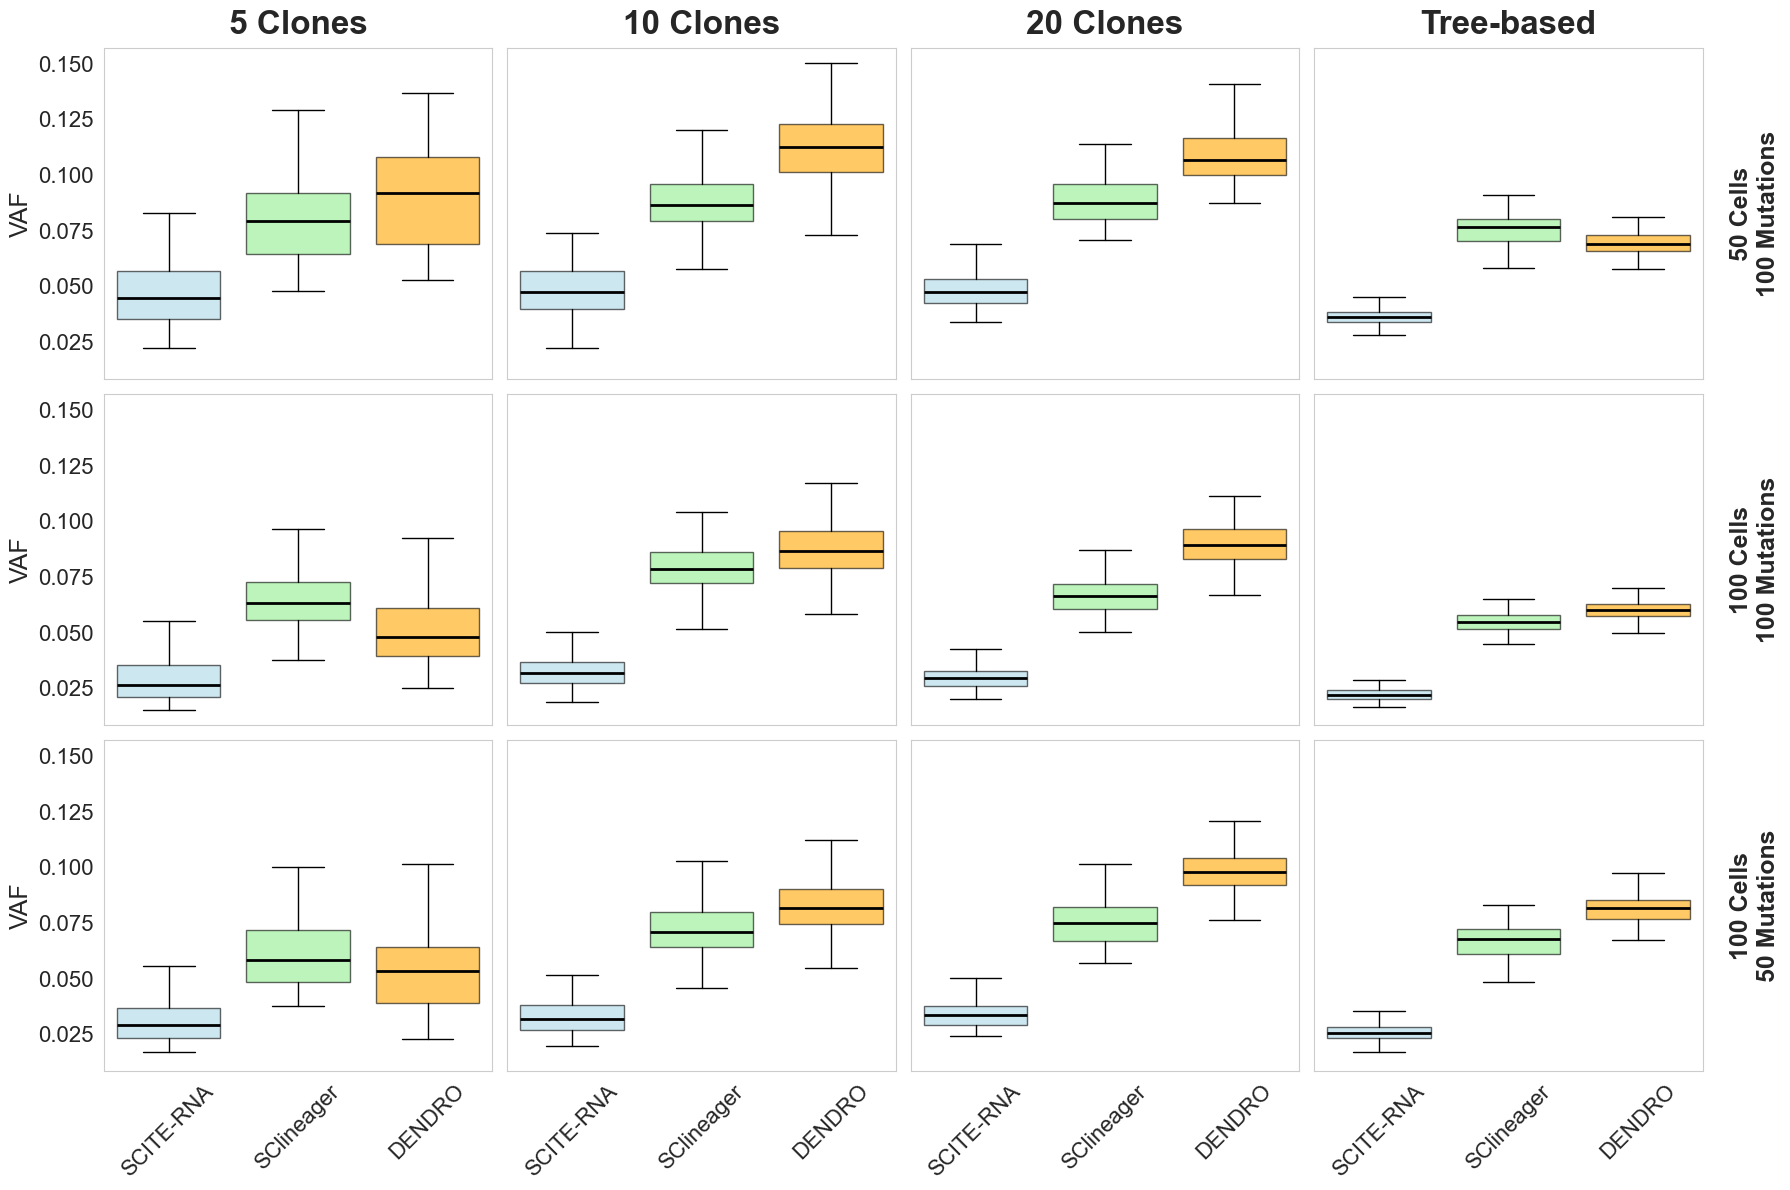

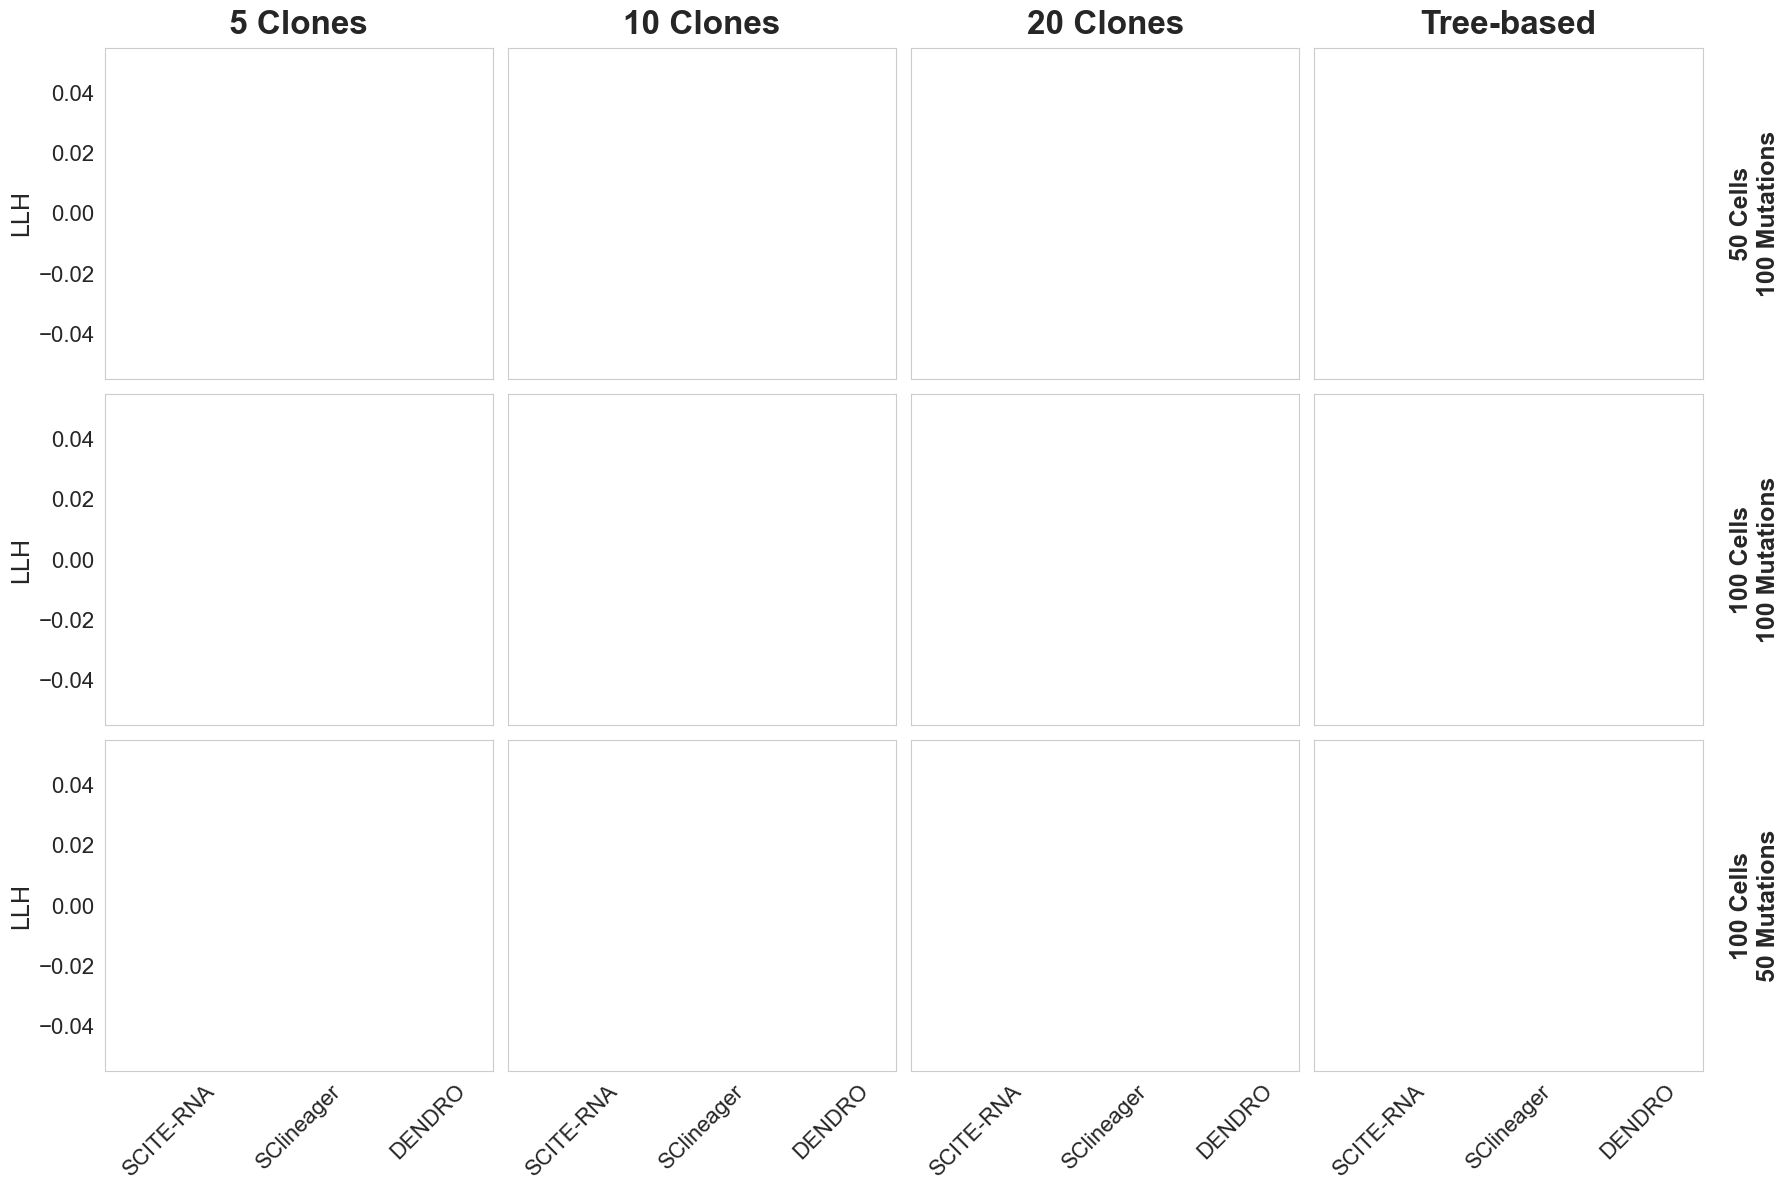

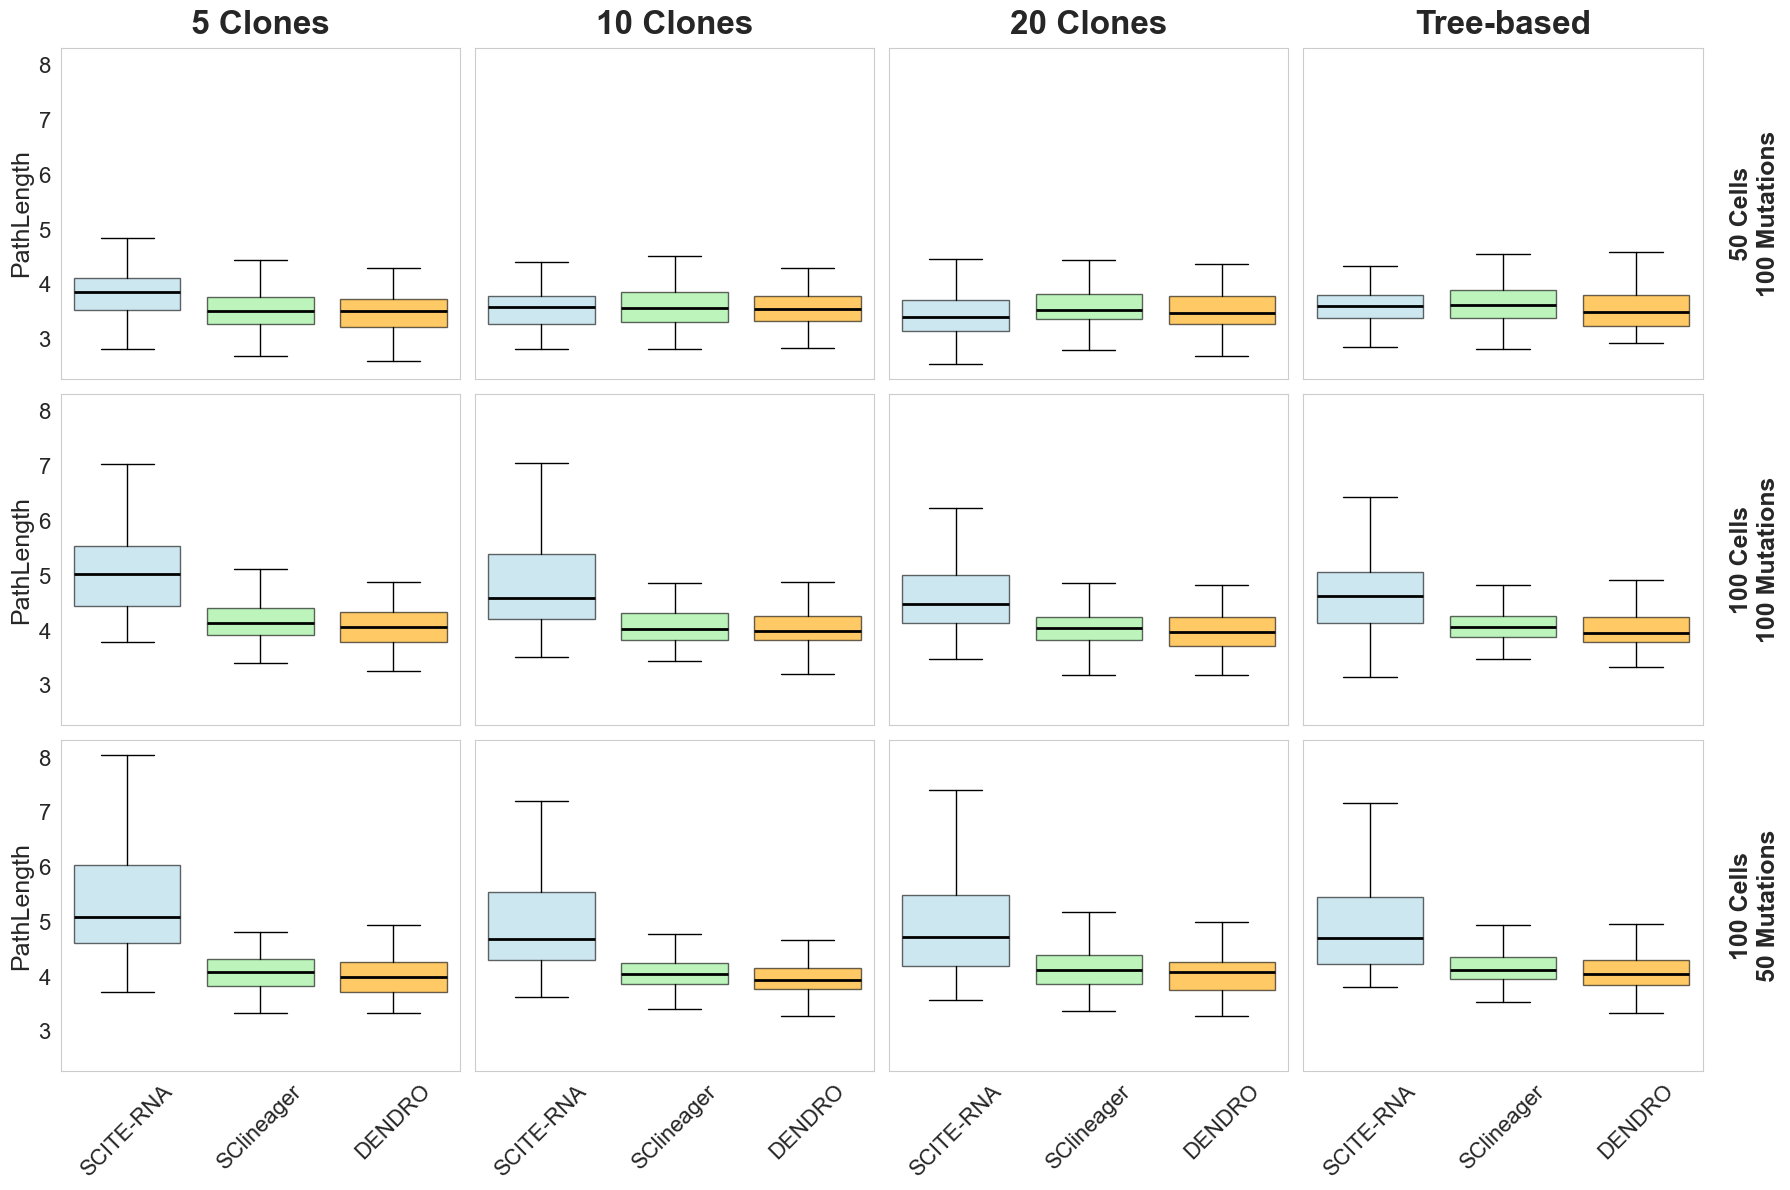

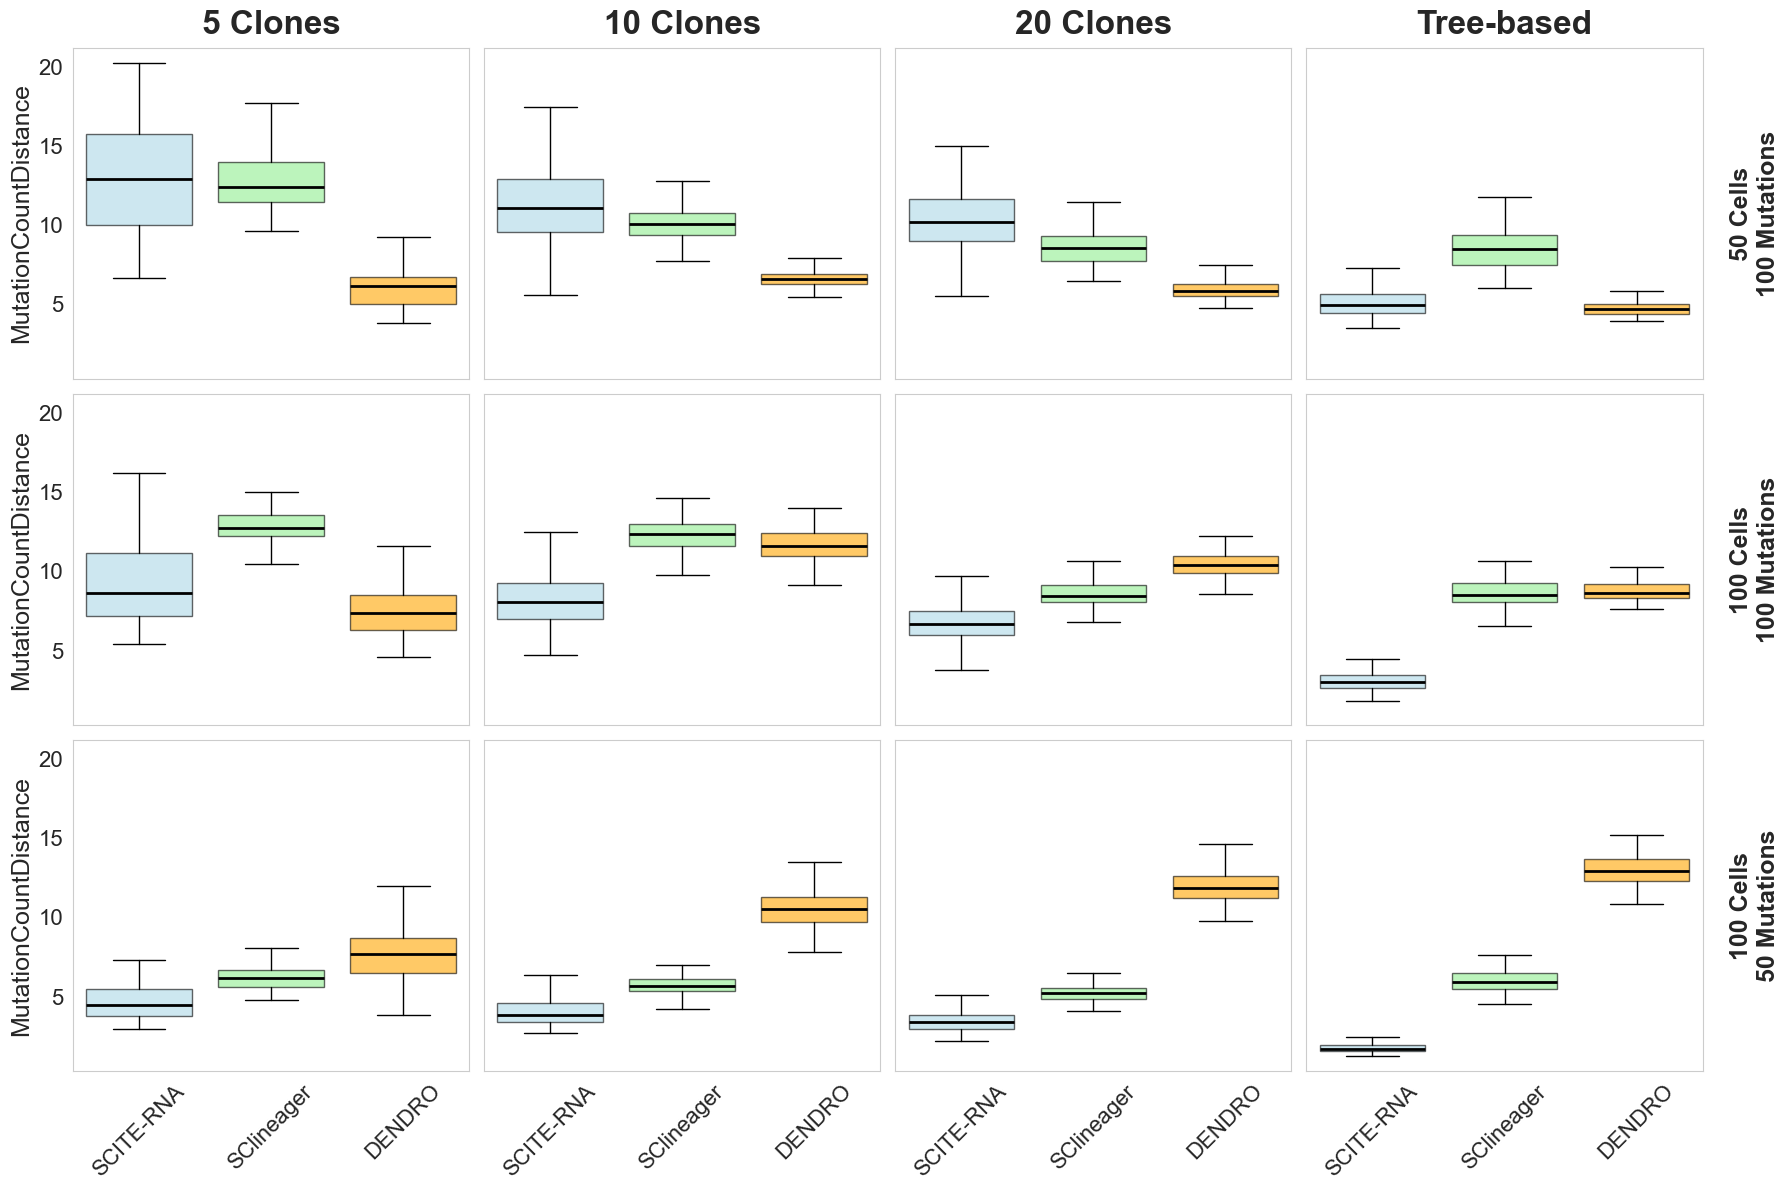

In [19]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

def plot_results(results_data, title=""):
    models = ["SCITE-RNA", "SClineager", "DENDRO"]

    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=True)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
        for col_idx, clone in enumerate(clones):
            all_samples = []
            for model in models:
                all_samples.append(results_data[model][f"{n_c}_{n_m}"][clone])
                # all_samples.append(path_len_differences[model][f"{n_c}_{n_m}"][clone])
                # all_samples.append(likelihood_differences[model][f"{n_c}_{n_m}"][clone])

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 2:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])  # Remove x-ticks for the higher rows

            if col_idx == 0:
                ax.set_ylabel(f'{title}', fontsize=label_size)
            if col_idx == 3:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size, rotation=90, labelpad=20, fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

    plt.tight_layout()
    plt.savefig(f"../data/results/figures/clones_{title}.png")
    plt.show()

plot_results(genotype_differences, "VAF")
plot_results(likelihood_differences, "LLH")
plot_results(path_len_differences, "PathLength")
plot_results(mut_count_differences, "MutationCountDistance")